---
<div align="center">

# LSDS | Machine Learning Pipeline
</div>

---
## Project Overview
---

### Background Overview
In critical care, accurately predicting the length of a patient’s stay in the ICU is essential for optimizing resource allocation and improving patient outcomes. The challenge stems from the complex interplay of diverse clinical factors — ranging from vital signs and laboratory results to administered treatments — which requires a concerted effort between clinical expertise and advanced data analytics to develop a robust solution.

---

### Available Data
The [MIMIC-III](https://physionet.org/content/mimiciii/1.4/) dataset, curated by the Massachusetts Institute of Technology, is one of the most comprehensive open-access databases for critical care research. It offers a wealth of de-identified data, including patient demographics, vital signs, lab results, and treatment details, which are invaluable for developing machine learning models.

---

### Approach / Methodology
We will begin by isolating the most relevant data from the MIMIC dataset using Google Cloud’s BigQuery service, which is well-suited to handle such high-volume datasets efficiently. Through extensive Exploratory Data Analysis (EDA), we aim to identify the critical features and patterns that influence patient outcomes. This initial phase will guide the selection of pertinent variables, setting the foundation for a robust predictive model.

---

### Machine Learning Pipeline
The final stage involves constructing a comprehensive machine learning pipeline. This pipeline will cover all steps from data preprocessing and feature engineering to model training and validation. By integrating profiling throughout our workflow, we ensure that performance metrics—such as execution time and resource usage—are continually monitored, a crucial aspect given the volume of data we are working with. This approach will help us fine-tune our chosen machine learning algorithm, ultimately providing a dependable prediction model for ICU length of stay.

---

### Conclusions
In conclusion, by leveraging BigQuery for efficient data extraction and performing a comprehensive exploratory analysis of the MIMIC dataset, we hope to develop a robust machine learning pipeline to predict ICU length of stay. This project aims to achieve more accurate and timely predictions, ultimately supporting improved resource allocation, enhanced clinical decision-making, and better patient outcomes in critical care settings.

---

### Additional Considerations
Each step of the pipeline — from data extraction and preprocessing to model training and validation—has been carefully profiled to monitor execution time, resource usage, and potential bottlenecks. This systematic profiling not only ensures that our solution scales effectively with high volumes of data but also provides valuable insights for continuous optimization of the overall process.

---
## Project Dependencies
---

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Remove Warnings
import warnings
warnings.filterwarnings('ignore')
from time import (time)

In [75]:
import pandas
pandas.read_gbq

<function pandas.io.gbq.read_gbq(query: 'str', project_id: 'str | None' = None, index_col: 'str | None' = None, col_order: 'list[str] | None' = None, reauth: 'bool' = False, auth_local_webserver: 'bool' = True, dialect: 'str | None' = None, location: 'str | None' = None, configuration: 'dict[str, Any] | None' = None, credentials: 'Credentials | None' = None, use_bqstorage_api: 'bool | None' = None, max_results: 'int | None' = None, progress_bar_type: 'str | None' = None) -> 'DataFrame'>

In [3]:
# Get the starting time before importing the modules
startTime = time()

# Import modules
import numpy as np
import pandas as pd
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.sql.types import ArrayType, StringType, BooleanType
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from google.cloud import storage
from google.cloud import bigquery
from pprint import pprint

# Custom Imports
from Utils import (loadConfig, loadPathsConfig)
from DataPreprocessing.DatasetManager import (DatasetManager)
from DataPreprocessing.DaskDataFrame import (DaskDataframe)
from DataPreprocessing.DatasetAnalyser import (DatasetAnalyser)

# Print the amount of time it took to import everything
print(f"Took{(time() - startTime) : .3e}(s) to import all the modules!")

Took 1.155e+01(s) to import all the modules!


In [4]:
# Load the configs
config = loadConfig()
pathsConfig = loadPathsConfig()

In [5]:
# Print the configs
pprint(config)
pprint(pathsConfig)

{'seed': 14, 'targetFeature': 'LOS'}
{'Datasets': {'ADMISSIONS': './Datasets/ADMISSIONS.csv',
              'CHARTEVENTS': './Datasets/CHARTEVENTS.csv',
              'DIAGNOSES_ICD': './Datasets/DIAGNOSES_ICD.csv',
              'ICUSTAYS': './Datasets/ICUSTAYS.csv',
              'PATIENTS': './Datasets/PATIENTS.csv'}}


In [6]:
# Define the path to the environment key
key = './ml-pipeline-key.json'

---
<div align="center">

## Exploratory Data Analysis
</div>

---

Given the MIMIC dataset, we aim to obtain greater insights on how the data is organized within the multiple tables and gain a better understanding on how we can harness the data to properly train a Machine Learning Model to help us correctly predict the Length of Stay (LOS) of a given patient that entered the Intensive Care Unit (ICU).

---
### MIMIC-III Dataset
---

The [MIMIC-III](https://physionet.org/content/mimiciii/1.4/) Dataset contains multiple tables from which we are going to select the ones that provide a greater value to our project and further analyse them to better gain a better understanding of the available data. Furthermore, its important to notice that we have uploaded the tables from the dataset onto the google cloud BigQuery Service to help us properly manage these high volumes of data.

Since our project focuses on predicting ICU length of stay, MIMIC provides a robust platform to explore complex clinical patterns and build predictive models that can help optimize patient care and resource allocation.

> MENTION ALL THE TABLES ON THE DATASET AND WHY WE CHOSE THESE OVER THE OTHERS.

Consequently, we ended up selecting the following tables:

- ADMISSIONS
- DIAGNOSES_ICD
- ICUSTAYS
- PATIENTS

For more details regarding the tables within the dataset, feel free to inspect them [here](https://mimic.mit.edu/docs/iii/tables/chartevents/).

In [7]:
# Create a Client to query the data
client = bigquery.Client.from_service_account_json(key)

In [8]:
# Currently just an idea
class QueryPerformer:
    def __init__(self, client):
        self.client = client

    def query(self, queryStatement):
        queryJob = self.client.query(queryStatement)
        df = queryJob.to_dataframe()

---
#### CHARTEVENTS Table
---
> CHARTEVENTS contains all the charted data available for a patient. During their ICU stay, the primary repository of a patient’s information is their electronic chart. The electronic chart displays patients' routine vital signs and any additional information relevant to their care: ventilator settings, laboratory values, code status, mental status, and so on. As a result, the bulk of information about a patient’s stay is contained in CHARTEVENTS. Furthermore, even though laboratory values are captured elsewhere (LABEVENTS), they are frequently repeated within CHARTEVENTS. This occurs because it is desirable to display the laboratory values on the patient’s electronic chart, and so the values are copied from the database storing laboratory values to the database storing the CHARTEVENTS.

For the Chart Events Table we selected the following columns:

| | CHARTEVENTS   | Description                                                                                                      |
|-|:-------------:|:----------------------------------------------------------------------------------------------------------------:|
| | ROW_ID        | Unique row identifier for each record in the table                                                               |
| | SUBJECT_ID    | Unique identifier for each patient                                                                               |
| | HADM_ID       | Unique identifier for each hospital admission                                                                    |
| | ICUSTAY_ID    | Unique identifier for each ICU stay                                                                              |
|X| ITEMID        | Identifier for a single measurement type (e.g., heart rate) corresponding to a specific recorded measurement     |
| | CHARTTIME     | Timestamp when the observation was made, serving as a proxy for the actual measurement time.                     |
| | STORETIME     | Timestamp when the observation was manually input or validated by clinical staff                                 |
| | CGID          | Identifier for the caregiver who validated the measurement                                                       |
|X| VALUE         | Recorded value of the measurement; may be textual or numeric, with numeric data also stored in VALUENUM          |
|X| VALUENUM      | Numeric representation of the measurement value when applicable, otherwise null                                  |
| | VALUEUOM      | Unit of measurement for the recorded value, if appropriate                                                       |
|X| WARNING       | Metavision-specific flag indicating if a warning was raised during measurement                                   |
| | ERROR         | Metavision-specific flag indicating if an error occurred during the measurement process                          |
| | RESULTSTATUS  | CareVue-specific field indicating the type of measurement, such as 'Manual' or 'Automatic'                       |
| | STOPPED       | CareVue-specific field indicating whether the measurement was stopped                                            |

In [73]:
# # Define your query
# chartEventsQuery = (
#     """
#     SELECT 
#         ROW_ID,
#         SUBJECT_ID,
#         HADM_ID,
#         ICUSTAY_ID,
#         ITEMID,
#         CHARTTIME,
#         STORETIME,
#         CGID,
#         VALUENUM,
#         VALUEUOM,
#         WARNING,
#         ERROR,
#         RESULTSTATUS,
#         STOPPED
#     FROM `MIMIC.CHARTEVENTS`;
#     """
# )

# # Run the query
# queryJob = client.query(chartEventsQuery)

# # Wait for the job to complete and get the results
# results = queryJob.result()

# # Convert the results to a Pandas DataFrame
# chartEvents = queryJob.to_dataframe()

In [ ]:
# Check the first 3 rows
chartEvents.head(3)

In [ ]:
# Checking the dtypes of each feature
chartEvents.dtypes

In [ ]:
# Create an diagnoses analyser
chartEventsAnalyser = DatasetAnalyser(df=icuStays)

In [ ]:
# Plot feature Distributions 
# (Note: There is no need to plot the Distribution of any ID feature)
chartEventsAnalyser.plotFeatureDistributions(
    features=[
        ''
    ]
)

---
#### ADMISSIONS Table
---
> The ADMISSIONS table gives information regarding a patient’s admission to the hospital. Since each unique hospital visit for a patient is assigned a unique HADM_ID, the ADMISSIONS table can be considered as a definition table for HADM_ID. Information available includes timing information for admission and discharge, demographic information, the source of the admission, and so on.

For the Admissions Table we selected the following columns:

| | ADMISSIONS           | Description                                                                                       |
|-|:--------------------:|:-------------------------------------------------------------------------------------------------:|
|X| ADMISSION_TYPE       | Describes the nature of the admission (e.g., ELECTIVE, URGENT, NEWBORN, EMERGENCY)                |
| | ADMITTIME            | Timestamp indicating when the patient was admitted to the hospital                                |
| | DISCHTIME            | Timestamp indicating when the patient was discharged from the hospital                            |
| | DEATHTIME            | Timestamp recording the time of in-hospital death, if applicable                                  |
|X| INSURANCE            | Contains the insurance provider details for the patient                                           |
| | LANGUAGE             | Indicates the language spoken by the patient                                                      |
| | RELIGION             | Provides the patient's religious affiliation                                                      |
|X| MARITAL_STATUS       | Describes the patient's marital status                                                            |
|X| ETHNICITY            | Specifies the patient's ethnic background                                                         |
| | HOSPITAL_EXPIRE_FLAG | Binary indicator (1 or 0) showing whether the patient died during the hospital stay               |

In [133]:
# Define your query
admissionsQuery = (
    """
    SELECT 
        ADMISSION_TYPE,
        ADMITTIME,
        DISCHTIME,
        DEATHTIME,
        INSURANCE,
        LANGUAGE,
        RELIGION,
        MARITAL_STATUS,
        ETHNICITY,
        HOSPITAL_EXPIRE_FLAG
    FROM `MIMIC.ADMISSIONS`;
    """
)

# Run the query
queryJob = client.query(admissionsQuery)

# Wait for the job to complete and get the results
results = queryJob.result()

# Convert the results to a Pandas DataFrame
admissions = queryJob.to_dataframe()

In [137]:
# Check the first 3 rows
admissions.head(3)

,ADMISSION_TYPE,ADMITTIME,DISCHTIME,DEATHTIME,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,HOSPITAL_EXPIRE_FLAG
0,EMERGENCY,2111-01-24 11:53:00+00:00,2111-01-25 22:40:00+00:00,2111-01-25 22:40:00+00:00,Private,None,UNOBTAINABLE,SINGLE,WHITE,1
1,EMERGENCY,2150-09-05 17:49:00+00:00,2150-09-12 18:30:00+00:00,2150-09-12 18:30:00+00:00,Medicare,ENGL,CATHOLIC,WIDOWED,ASIAN - JAPANESE,1
2,EMERGENCY,2190-09-18 22:39:00+00:00,2190-09-24 20:40:00+00:00,2190-09-24 20:40:00+00:00,Medicaid,None,CATHOLIC,MARRIED,WHITE,1


In [102]:
# Checking the dtypes of each feature
admissions.dtypes

ADMISSION_TYPE                       object
ADMITTIME               datetime64[us, UTC]
DISCHTIME               datetime64[us, UTC]
DEATHTIME               datetime64[us, UTC]
INSURANCE                            object
LANGUAGE                             object
RELIGION                             object
MARITAL_STATUS                       object
ETHNICITY                            object
HOSPITAL_EXPIRE_FLAG                  Int64
dtype: object

In [117]:
# Create an admissions analyser
admissionAnalyser = DatasetAnalyser(df=admissions)

In [122]:
# Plot the distribution of Ethnicity
# admissionAnalyser.plotFeatureDistribution(feature='ETHNICITY')

In [125]:
# Plot the distribution of Language
# admissionAnalyser.plotFeatureDistribution(feature='LANGUAGE') 

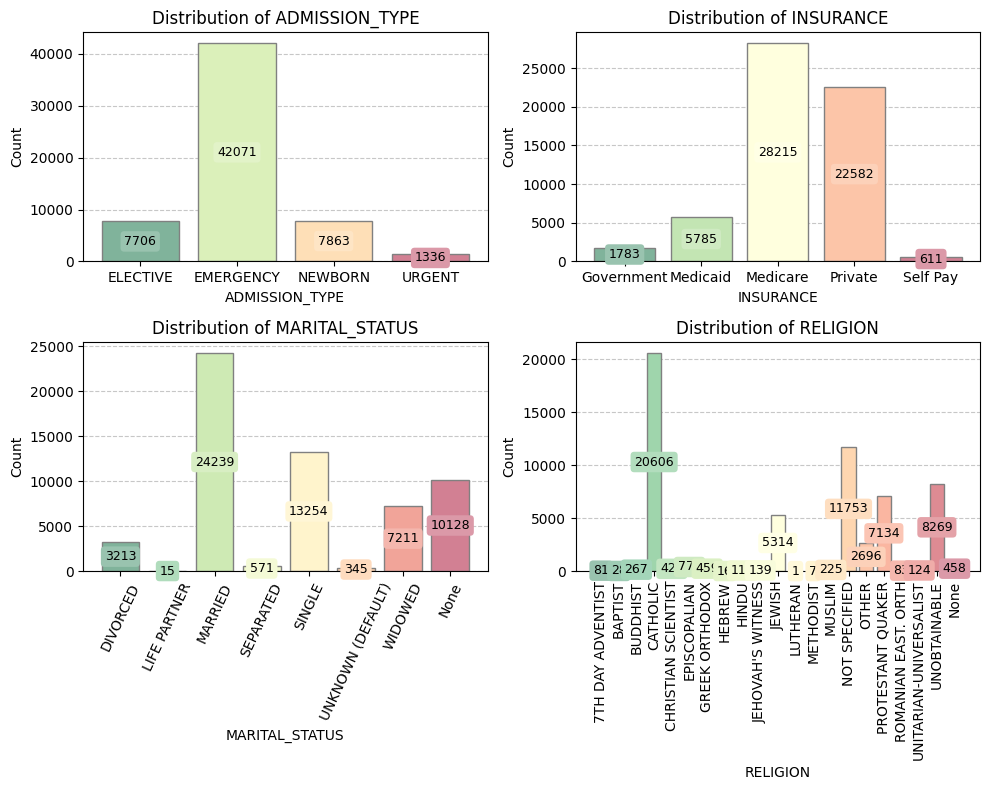

In [180]:
# Plot feature Distributions
# (Note: There is no need to plot the Distribution of any ID feature)
admissionAnalyser.plotFeatureDistributions(
    features=[
        'ADMISSION_TYPE',
        'INSURANCE',
        'MARITAL_STATUS',
        'RELIGION'
    ]
)

---
#### DIAGNOSES_ICD Table
---

> The DIAGNOSES_ICS table contains ICD diagnoses for patients, most notably ICD-9 diagnoses.

We have selected the following columns from this table:

| | DIAGNOSES_ICD | Description                                                                                                                          |
|-|:-------------:|:------------------------------------------------------------------------------------------------------------------------------------:|
| | SUBJECT_ID    | Unique identifier for each patient                                                                                                   |
| | HADM_ID       | Unique identifier for each hospital admission, defining a specific patient stay                                                      |
|X| SEQ_NUM       | Indicates the order or priority of the ICD diagnoses for the patient, which can affect treatment reimbursement                       |
|X| ICD9_CODE     | Contains the ICD-9 code corresponding to the diagnosis assigned to the patient during the hospital stay                              |

In [165]:
# Define your query
diagnosesICDQuery = (
    """
    SELECT 
        SUBJECT_ID,
        HADM_ID,
        SEQ_NUM,
        ICD9_CODE
    FROM `MIMIC.DIAGNOSES_ICD`;
    """
)

# Run the query
queryJob = client.query(diagnosesICDQuery)

# Wait for the job to complete and get the results
results = queryJob.result()

# Convert the results to a Pandas DataFrame
diagnoses = queryJob.to_dataframe()

In [166]:
# Check the first 3 rows
diagnoses.head(3)

,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,109,172335,1,40301
1,109,172335,2,486
2,109,172335,3,58281


In [167]:
# Checking the dtypes of each feature
diagnoses.dtypes

SUBJECT_ID     Int64
HADM_ID        Int64
SEQ_NUM        Int64
ICD9_CODE     object
dtype: object

In [173]:
# Checking the amount of different illnesses
print(f"There are in total {len(diagnoses['ICD9_CODE'].value_counts())} illnesses reported in the dataset!")

There are in total 6984 illnesses reported in the dataset!


Since the dataset has a **tremendous amount of unique illnesses**, we have decided **not to plot its distribution**.

In [168]:
# Create an diagnoses analyser
diagnosesAnalyser = DatasetAnalyser(df=diagnoses)

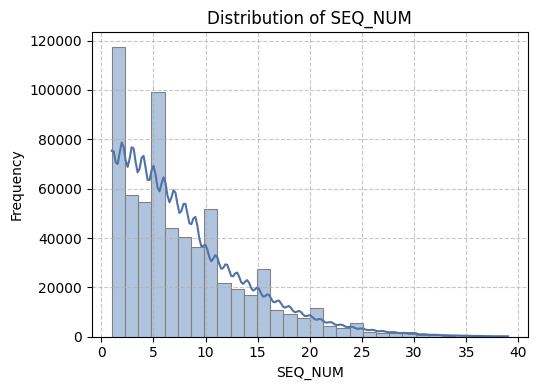

In [181]:
# Plot feature Distributions
# (Note: There is no need to plot the Distribution of any ID feature)
diagnosesAnalyser.plotFeatureDistributions(
    features=['SEQ_NUM']
)

---
#### ICUSTAYS Table
---

> The ICUSTAYS defines each ICUSTAY_ID in the database, i.e. defines a single ICU stay.

We have selected the following columns from this table:

| | ICUSTAYS          | Description                                                                                                                             |
|-|:-----------------:|:---------------------------------------------------------------------------------------------------------------------------------------:|
| | SUBJECT_ID        | Unique identifier for each patient.                                                                                                     |
| | HADM_ID           | Unique identifier for each hospital admission, defining a specific patient stay.                                                        |
| | ICUSTAY_ID        | Unique identifier for each ICU stay, representing a single ICU encounter.                                                               |
| | DBSOURCE          | Indicates the original ICU database source (e.g., 'carevue' for 2001–2008 or 'metavision' for 2008–2012), which affects data archiving. |
|X| FIRST_CAREUNIT    | The first ICU type where the patient was cared for during the ICU stay.                                                                 |
| | LAST_CAREUNIT     | The last ICU type where the patient was cared for, noting that transfers between ICU types can occur within a single stay.              |
| | FIRST_WARDID      | Identifier for the first ICU unit (ward) where the patient was admitted, as recorded in the hospital database.                          |
| | LAST_WARDID       | Identifier for the last ICU unit (ward) where the patient stayed during their ICU encounter.                                            |
| | INTIME            | Timestamp indicating when the patient was transferred into the ICU.                                                                     |
| | OUTTIME           | Timestamp indicating when the patient was transferred out of the ICU.                                                                   |
|X| LOS               | Length of stay for the ICU encounter, measured in fractional days, which may encompass multiple ICU units.                              |

In [175]:
# Define your query
staysICUQuery = (
    """
    SELECT 
        SUBJECT_ID,
        HADM_ID,
        ICUSTAY_ID,
        DBSOURCE,
        FIRST_CAREUNIT,
        LAST_CAREUNIT,
        FIRST_WARDID,
        LAST_WARDID,
        INTIME,
        OUTTIME,
        LOS
    FROM `MIMIC.ICUSTAYS`;
    """
)

# Run the query
queryJob = client.query(staysICUQuery)

# Wait for the job to complete and get the results
results = queryJob.result()

# Convert the results to a Pandas DataFrame
icuStays = queryJob.to_dataframe()

In [176]:
# Check the first 3 rows
icuStays.head(3)

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS
0,275,129886,219649,carevue,CCU,CCU,7,7,2170-10-07 11:28:53+00:00,2170-10-14 14:38:07+00:00,7.1314
1,291,113649,256641,carevue,CCU,CCU,7,7,2102-04-08 23:05:28+00:00,2102-04-09 11:20:11+00:00,0.5102
2,291,125726,275109,metavision,CCU,CCU,7,7,2106-04-17 12:26:17+00:00,2106-04-18 22:05:39+00:00,1.4023


In [177]:
# Checking the dtypes of each feature
icuStays.dtypes

SUBJECT_ID                      Int64
HADM_ID                         Int64
ICUSTAY_ID                      Int64
DBSOURCE                       object
FIRST_CAREUNIT                 object
LAST_CAREUNIT                  object
FIRST_WARDID                    Int64
LAST_WARDID                     Int64
INTIME            datetime64[us, UTC]
OUTTIME           datetime64[us, UTC]
LOS                           float64
dtype: object

In [178]:
# Create an diagnoses analyser
icuStaysAnalyser = DatasetAnalyser(df=icuStays)

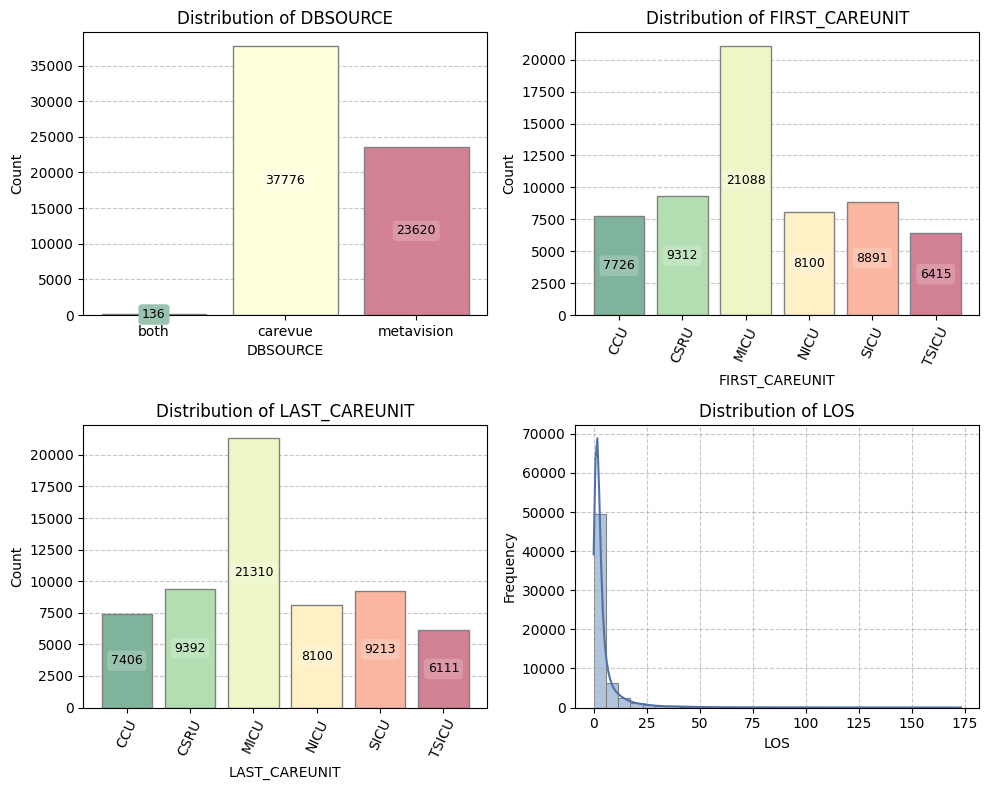

In [182]:
# Plot feature Distributions 
# (Note: There is no need to plot the Distribution of any ID feature)
icuStaysAnalyser.plotFeatureDistributions(
    features=[
        'DBSOURCE',
        'FIRST_CAREUNIT',
        'LAST_CAREUNIT',
        'LOS'
    ]
)

---
#### PATIENTS Table
---

> The PATIENTS table defines each SUBJECT_ID in the database, i.e. defines a single patient.

For this table we have selected the upcoming columns:

| | PATIENTS     | Description                                                                                                                                          |
|-|:------------:|:----------------------------------------------------------------------------------------------------------------------------------------------------:|
| | SUBJECT_ID   | Unique identifier for each patient, used to link patient data across tables.                                                                         |
|X| GENDER       | The genotypical sex of the patient.                                                                                                                  |
|X| DOB          | Date of birth of the patient. For patients older than 89, DOB is shifted (set to 300 years before the first admission) for HIPAA compliance.         |
| | DOD          | Date of death for the patient, merging information from hospital (DOD_HOSP) and social security (DOD_SSN) records, with DOD_HOSP taking priority.    |
| | DOD_HOSP     | Date of death as recorded in the hospital database.                                                                                                  |
| | DOD_SSN      | Date of death from the social security database.                                                                                                     |
| | EXPIRE_FLAG  | Binary flag indicating whether the patient died (i.e., whether DOD is not null).                                                                     |

In [183]:
# Define your query
patientsQuery = (
    """
    SELECT 
        SUBJECT_ID,
        GENDER,
        DOB,
        DOD,
        DOD_HOSP,
        DOD_SSN,
        EXPIRE_FLAG
    FROM `MIMIC.PATIENTS`;
    """
)

# Run the query
queryJob = client.query(patientsQuery)

# Wait for the job to complete and get the results
results = queryJob.result()

# Convert the results to a Pandas DataFrame
patients = queryJob.to_dataframe()

In [184]:
# Check the first 3 rows
patients.head(3)

,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,249,F,2075-03-13 00:00:00+00:00,NaT,NaT,NaT,0
1,253,F,2089-11-26 00:00:00+00:00,NaT,NaT,NaT,0
2,258,F,2124-09-19 00:00:00+00:00,NaT,NaT,NaT,0


In [185]:
# Checking the dtypes of each feature
patients.dtypes

SUBJECT_ID                   Int64
GENDER                      object
DOB            datetime64[us, UTC]
DOD            datetime64[us, UTC]
DOD_HOSP       datetime64[us, UTC]
DOD_SSN        datetime64[us, UTC]
EXPIRE_FLAG                  Int64
dtype: object

In [186]:
# Create an patients analyser
patientsAnalyser = DatasetAnalyser(df=patients)

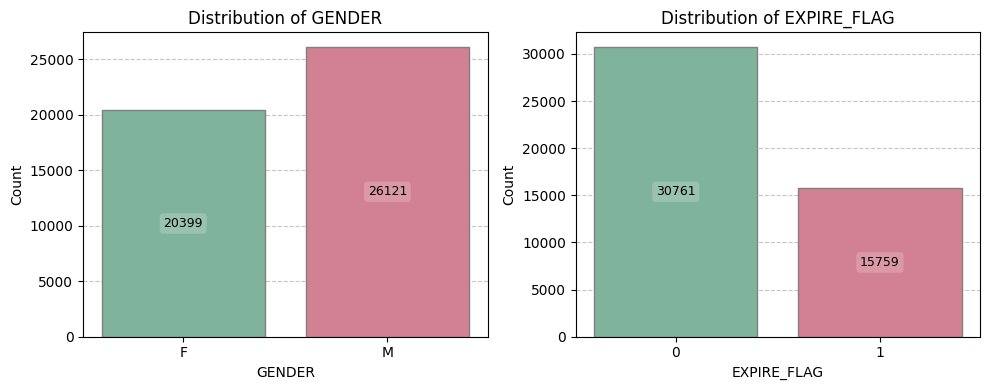

In [189]:
# Plot feature Distributions 
# (Note: There is no need to plot the Distribution of any ID feature)
patientsAnalyser.plotFeatureDistributions(
    features=[
        'GENDER',
        'EXPIRE_FLAG'
    ],
    forceCategorical=True
)

---
<div align="center">

## Additional Analysis
</div>

---

We barely scrapped the surface with the previous analysis, so let's try to achieve greater insights with the data! By leveraging the data from the available tables, let's try to derive new information from them.

---
### The most Common Ilnesses
---

In [52]:
# Define your query
mostCommonIllnessesQuery = (
    """
    SELECT 
        descriptionDiagnoses.SHORT_TITLE AS ILLNESS,
        COUNT(*) AS TOTAL_CASES
    FROM `MIMIC.DIAGNOSES_ICD` AS diagnoses
        JOIN `MIMIC.D_ICD_DIAGNOSES` AS descriptionDiagnoses
            ON diagnoses.ICD9_CODE = descriptionDiagnoses.ICD9_CODE
    GROUP BY descriptionDiagnoses.SHORT_TITLE
    ORDER BY TOTAL_CASES DESC;
    """
)

# Run the query
queryJob = client.query(mostCommonIllnessesQuery)

# Wait for the job to complete and get the results
results = queryJob.result()

# Convert the results to a Pandas DataFrame
mostCommonIllnesses = queryJob.to_dataframe()

In [53]:
# Showcase the most common illnesses on the ICU
mostCommonIllnesses.head()

,ILLNESS,TOTAL_CASES
0,Hypertension NOS,20703
1,CHF NOS,13111
2,Atrial fibrillation,12891
3,Crnry athrscl natve vssl,12429
4,Acute kidney failure NOS,9119


---
### Deseases with a Higher Length of Stay
---

As any Hospital is interested on their patients, it can be quite fulcral to have a deep understanding of the deseases that most likely lead to a higher length of stay in Intensive Unit Care in order to raise a higher awareness to all the medical professionals towards the extra need of medical supplies, technicians and equipment to better maitain and serve the Hospital when someone enters the ICU with such deseases.

In [47]:
# Define your query
illnessLOSQuery = (
    """
    WITH ILLNESS_LOS AS (
        SELECT 
            diagnoses.ICD9_CODE,
            AVG(icuStays.LOS) AS AVG_LOS
        FROM `MIMIC.DIAGNOSES_ICD` AS diagnoses
        JOIN `MIMIC.ICUSTAYS` AS icuStays
              ON diagnoses.SUBJECT_ID = icuStays.SUBJECT_ID 
             AND diagnoses.HADM_ID = icuStays.HADM_ID
        GROUP BY diagnoses.ICD9_CODE
    )
    SELECT
        descriptionDiagnoses.SHORT_TITLE AS ILLNESS,
        illnesses.AVG_LOS
    FROM ILLNESS_LOS AS illnesses
        JOIN `MIMIC.D_ICD_DIAGNOSES` AS descriptionDiagnoses
          ON illnesses.ICD9_CODE = descriptionDiagnoses.ICD9_CODE
    ORDER BY illnesses.AVG_LOS DESC;
    """
)

# Run the query
queryJob = client.query(illnessLOSQuery)

# Wait for the job to complete and get the results
results = queryJob.result()

# Convert the results to a Pandas DataFrame
illnessLOS = queryJob.to_dataframe()

In [48]:
# Showcase the illnesses that, in average lead to a longer length of stay on the ICU
illnessLOS.head()

,ILLNESS,AVG_LOS
0,Septic myocarditis,153.928000
1,Instantaneous death,119.164200
2,Nasal mucositis (ulcer),119.164200
3,NB hemorrhagic disease,98.354900
4,Fet growth ret 500-749g,96.550333


---
### The Deadliest Ilnesses
---

In [50]:
# Define your query
deadliestIllnessesQuery = (
    """
    SELECT 
        descriptionDiagnoses.SHORT_TITLE AS ILLNESS,
        COUNT(*) AS TOTAL_DEATHS
    FROM `MIMIC.DIAGNOSES_ICD` AS diagnoses
        JOIN `MIMIC.PATIENTS` AS patients
            ON diagnoses.SUBJECT_ID = patients.SUBJECT_ID
        JOIN `MIMIC.D_ICD_DIAGNOSES` AS descriptionDiagnoses
            ON diagnoses.ICD9_CODE = descriptionDiagnoses.ICD9_CODE
    WHERE patients.EXPIRE_FLAG = 1
    GROUP BY descriptionDiagnoses.SHORT_TITLE
    ORDER BY TOTAL_DEATHS DESC;
    """
)

# Run the query
queryJob = client.query(deadliestIllnessesQuery)

# Wait for the job to complete and get the results
results = queryJob.result()

# Convert the results to a Pandas DataFrame
deadliestIllnesses = queryJob.to_dataframe()

In [51]:
# Showcase the top 10 deadliest illnesses
deadliestIllnesses.head()

,ILLNESS,TOTAL_DEATHS
0,Hypertension NOS,8333
1,CHF NOS,8020
2,Atrial fibrillation,7290
3,Acute kidney failure NOS,5432
4,Crnry athrscl natve vssl,5004


---
### Mortality Rates
---
> Explore how mortality rates differ among patient groups (e.g., by insurance type, age group, or specific ICU units).


---
#### Gender
---

In [9]:
# Define your query
genderMortalityRatesQuery = (
    """
    WITH TOTAL_PATIENTS_GENDER AS (
        SELECT 
            GENDER,
            COUNT(*) AS TOTAL_PATIENTS
        FROM `MIMIC.PATIENTS` AS patients
        GROUP BY patients.GENDER
    )
    SELECT 
        patients.GENDER,
        COUNT(*) AS TOTAL_DEATHS,
        t.TOTAL_PATIENTS,
        COUNT(*) / t.TOTAL_PATIENTS AS MORTALITY_RATIO
    FROM `MIMIC.PATIENTS` AS patients
        JOIN TOTAL_PATIENTS_GENDER AS t 
            ON (patients.GENDER = t.GENDER)
    WHERE EXPIRE_FLAG = 1
    GROUP BY GENDER, TOTAL_PATIENTS
    ORDER BY MORTALITY_RATIO DESC;
    """
)

# Run the query
queryJob = client.query(genderMortalityRatesQuery)

# Wait for the job to complete and get the results
results = queryJob.result()

# Convert the results to a Pandas DataFrame
genderMortalityRates = queryJob.to_dataframe()

In [10]:
# Showcase the mortality ratio between male and female patients
genderMortalityRates.head()

,GENDER,TOTAL_DEATHS,TOTAL_PATIENTS,MORTALITY_RATIO
0,F,7235,20399,0.354674
1,M,8524,26121,0.326327


---
#### Ethnicity
---

In [64]:
# Define your query
ethnicityMortalityRatesQuery = (
    """
    WITH ETHNICITIES_TABLE AS (
        SELECT
          SUBJECT_ID,
          CASE 
            WHEN UPPER(ETHNICITY) LIKE '%WHITE%' 
                 AND UPPER(ETHNICITY) NOT LIKE '%HISPANIC%' 
                 THEN 'White/European'
            WHEN UPPER(ETHNICITY) LIKE '%BLACK%' 
                 THEN 'Black/African American'
            WHEN UPPER(ETHNICITY) LIKE '%ASIAN%' 
                 THEN 'Asian'
            WHEN UPPER(ETHNICITY) LIKE '%HISPANIC%' 
                 OR UPPER(ETHNICITY) LIKE '%LATINO%' 
                 THEN 'Hispanic/Latino'
            WHEN UPPER(ETHNICITY) LIKE '%AMERICAN INDIAN%' 
                 OR UPPER(ETHNICITY) LIKE '%ALASKA NATIVE%' 
                 THEN 'Native American'
            WHEN UPPER(ETHNICITY) LIKE '%NATIVE HAWAIIAN%' 
                 OR UPPER(ETHNICITY) LIKE '%PACIFIC ISLANDER%' 
                 THEN 'Pacific Islander'
            WHEN UPPER(ETHNICITY) LIKE '%UNKNOWN%'
                 OR UPPER(ETHNICITY) LIKE '%UNABLE%'
                 OR UPPER(ETHNICITY) LIKE '%DECLINED%'
                 THEN 'Unknown/Not Provided'
            ELSE 'Other'
          END AS ETHNICITY_GROUP
        FROM `MIMIC.ADMISSIONS`
        GROUP BY SUBJECT_ID, ETHNICITY_GROUP
    ),
    PATIENTS_ETHNICITIES AS (
        SELECT
            ethnicities.SUBJECT_ID,
            ETHNICITY_GROUP
        FROM ETHNICITIES_TABLE AS ethnicities
            JOIN `MIMIC.ADMISSIONS` as admissions
                ON (ethnicities.SUBJECT_ID = admissions.SUBJECT_ID)
        GROUP BY ethnicities.SUBJECT_ID, ethnicities.ETHNICITY_GROUP
    ),
    TOTAL_PATIENTS_ETHNICITIES AS (
        SELECT 
            ETHNICITY_GROUP,
            COUNT(*) AS TOTAL_PATIENTS
        FROM PATIENTS_ETHNICITIES
        GROUP BY ETHNICITY_GROUP
    )
    SELECT 
        t.ETHNICITY_GROUP,
        COUNT(*) AS TOTAL_DEATHS,
        t.TOTAL_PATIENTS,
        COUNT(*) / t.TOTAL_PATIENTS AS MORTALITY_RATIO
    FROM `MIMIC.PATIENTS` as patients
        JOIN PATIENTS_ETHNICITIES as patientsEthnicities
            ON (patients.SUBJECT_ID = patientsEthnicities.SUBJECT_ID) 
        JOIN TOTAL_PATIENTS_ETHNICITIES AS t 
            ON (patientsEthnicities.ETHNICITY_GROUP = t.ETHNICITY_GROUP)
    WHERE EXPIRE_FLAG = 1
    GROUP BY ETHNICITY_GROUP, TOTAL_PATIENTS
    ORDER BY TOTAL_PATIENTS DESC;
    """
)

# Run the query
queryJob = client.query(ethnicityMortalityRatesQuery)

# Wait for the job to complete and get the results
results = queryJob.result()

# Convert the results to a Pandas DataFrame
ethnicityMortalityRates = queryJob.to_dataframe()

In [66]:
# Showcase the mortality ratio within all the patient's ethnicities
ethnicityMortalityRates

,ETHNICITY_GROUP,TOTAL_DEATHS,TOTAL_PATIENTS,MORTALITY_RATIO
0,White/European,11448,32433,0.352974
1,Unknown/Not Provided,2314,5530,0.418445
2,Black/African American,1099,3875,0.283613
3,Asian,326,1691,0.192785
4,Hispanic/Latino,321,1652,0.194310
5,Other,311,1511,0.205824
6,Native American,11,47,0.234043
7,Pacific Islander,5,15,0.333333


---
#### Care Units
---

We now will analyse how the initial care units can impact the outcome of the patient (if he lives or dies) and its length of stay in 

In [139]:
# Define your query
icuMortalityQuery = (
    """
    WITH CAREUNIT_PATIENTS AS (
        SELECT 
            FIRST_CAREUNIT,
            COUNT(*) AS TOTAL_PATIENTS
        FROM `MIMIC.PATIENTS` AS patients
            JOIN `MIMIC.ICUSTAYS` AS icuStays
                ON patients.SUBJECT_ID = icuStays.SUBJECT_ID
        GROUP BY FIRST_CAREUNIT
    )
    SELECT 
        careunitPatients.FIRST_CAREUNIT,
        COUNT(*) AS TOTAL_DEATHS,
        careunitPatients.TOTAL_PATIENTS,
        COUNT(*) / careunitPatients.TOTAL_PATIENTS AS MORTALITY_RATIO
    FROM `MIMIC.PATIENTS` AS patients
        JOIN `MIMIC.ICUSTAYS` AS icuStays
            ON patients.SUBJECT_ID = icuStays.SUBJECT_ID
        JOIN CAREUNIT_PATIENTS AS careunitPatients
            ON careunitPatients.FIRST_CAREUNIT = icuStays.FIRST_CAREUNIT
    WHERE EXPIRE_FLAG = 1
    GROUP BY FIRST_CAREUNIT, TOTAL_PATIENTS
    ORDER BY MORTALITY_RATIO DESC;
    """
)

# Run the query
queryJob = client.query(icuMortalityQuery)

# Wait for the job to complete and get the results
results = queryJob.result()

# Convert the results to a Pandas DataFrame
icuMortality = queryJob.to_dataframe()

In [140]:
# Showcase how each initial care unit can impact the treatment of the patient
icuMortality.head()

,FIRST_CAREUNIT,TOTAL_DEATHS,TOTAL_PATIENTS,MORTALITY_RATIO
0,MICU,11433,21088,0.542157
1,CCU,3856,7726,0.499094
2,SICU,3984,8891,0.448094
3,TSICU,2246,6415,0.350117
4,CSRU,2605,9312,0.279747


---
#### XXX
---

In [70]:
# Define your query
query = (
    """
    -- Unified view combining ADMISSIONS and PATIENTS data
    WITH admissions_patient AS (
      SELECT 
        adm.SUBJECT_ID,
        adm.HADM_ID,
        adm.ADMITTIME,
        adm.DISCHTIME,
        adm.HOSPITAL_EXPIRE_FLAG,
        adm.ETHNICITY,
        adm.MARITAL_STATUS,
        adm.RELIGION,
        -- Compute LOS in days (using hours divided by 24)
        TIMESTAMP_DIFF(adm.DISCHTIME, adm.ADMITTIME, HOUR) / 24.0 AS LOS
      FROM `MIMIC.ADMISSIONS` AS adm
      JOIN `MIMIC.PATIENTS` AS pat
        ON adm.SUBJECT_ID = pat.SUBJECT_ID
    ),
    
    -- Count total admissions per patient (useful for readmission analysis)
    patient_admission_counts AS (
      SELECT 
        SUBJECT_ID,
        COUNT(*) AS admission_count
      FROM `MIMIC.ADMISSIONS`
      GROUP BY SUBJECT_ID
    )
    
    -- 3. Readmission Rate by Ethnicity (percentage of patients with >1 admission)
    SELECT
      ap.ETHNICITY,
      COUNT(DISTINCT ap.SUBJECT_ID) AS total_patients,
      SUM(CASE WHEN pac.admission_count > 1 THEN 1 ELSE 0 END) AS readmitted_patients,
      SAFE_DIVIDE(SUM(CASE WHEN pac.admission_count > 1 THEN 1 ELSE 0 END), COUNT(DISTINCT ap.SUBJECT_ID)) AS readmission_rate
    FROM admissions_patient AS ap
    JOIN patient_admission_counts AS pac
      ON ap.SUBJECT_ID = pac.SUBJECT_ID
    GROUP BY ap.ETHNICITY
    ORDER BY readmission_rate DESC;
    """
)

# Run the query
queryJob = client.query(query)

# Wait for the job to complete and get the results
results = queryJob.result()

# Convert the results to a Pandas DataFrame
res = queryJob.to_dataframe()

In [ ]:
 # -- 1. Average Length of Stay (LOS) by Ethnicity
 #    SELECT
 #      ETHNICITY,
 #      COUNT(*) AS total_admissions,
 #      AVG(LOS) AS avg_los
 #    FROM admissions_patient
 #    GROUP BY ETHNICITY
 #    ORDER BY avg_los DESC;
    
 #    -- 2. Mortality Ratio by Ethnicity
 #    SELECT 
 #      ETHNICITY,
 #      COUNT(*) AS total_admissions,
 #      SUM(CASE WHEN HOSPITAL_EXPIRE_FLAG = 1 THEN 1 ELSE 0 END) AS total_deaths,
 #      SAFE_DIVIDE(SUM(CASE WHEN HOSPITAL_EXPIRE_FLAG = 1 THEN 1 ELSE 0 END), COUNT(*)) AS mortality_ratio
 #    FROM admissions_patient
 #    GROUP BY ETHNICITY
 #    ORDER BY mortality_ratio DESC;

In [71]:
# Showcase how each initial care unit can impact the treatment of the patient
res.head()

,ETHNICITY,total_patients,readmitted_patients,readmission_rate
0,AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...,2,2,1.000000
1,ASIAN - FILIPINO,15,14,0.933333
2,ASIAN - CAMBODIAN,11,10,0.909091
3,PORTUGUESE,40,34,0.850000
4,HISPANIC/LATINO - CENTRAL AMERICAN (OTHER),9,7,0.777778


---
## Additional Ideas:

- Outlier Analysis on LOS:
- Assess how frequently ICD-9 codes appear together, identifying common comorbidities.
- Assess how variables like ethnicity, marital status, or religion (from ADMISSIONS and PATIENTS tables) correlate with length of stay, mortality, or readmission rates.
- Demographic Correlations: Join the PATIENTS and ADMISSIONS tables to explore correlations between age, gender, or ethnicity and LOS, potentially revealing disparities in outcomes.

---
<div align="center">

## Data Preprocessing
</div>

---

Given the previous extended exploratory data analysis, we are bound to manipulate the dataset's tables in order to obtain a more robust and precise dataframe with whoose help alongside some data preparation will allow us to properly train a machine learning model to correctly predict the Length of Stay of patients in the Intensive Care Unit.